In [25]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import randint, uniform

In [ ]:
import tensorflow as tf

## IMPORT & EXPLORE

#### FUNCTIONS

In [ ]:
def display_examples(images, labels=None, reconstructed_images=None, num_examples=5, mode="single"):
    """
    Display original images (and optionally compare with reconstructed ones).

    Parameters:
    - images: List or array of original images.
    - labels: List of labels (optional).
    - reconstructed_images: List or array of reconstructed images (optional).
    - num_examples: Number of examples to display.
    - mode: "single" to show only originals, "compare" to show originals vs reconstructed.
    """
    plt.figure(figsize=(num_examples * 2, 4 if mode == "single" else 6))

    for i in range(num_examples):
        # Original image
        ax = plt.subplot(2 if mode == "compare" else 1, num_examples, i + 1)
        ax.imshow(images[i])
        if labels is not None:
            ax.set_title(f"Label: {labels[i]}")
        ax.axis("off")

        # Reconstructed image (only in compare mode)
        if mode == "compare" and reconstructed_images is not None:
            ax = plt.subplot(2, num_examples, i + 1 + num_examples)
            ax.imshow(reconstructed_images[i])
            ax.set_title("Reconstructed")
            ax.axis("off")

    plt.tight_layout()
    plt.show()


#### DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#### COLAB VERSION

flip_book_images = np.load("/content/drive/MyDrive/Data Science/flip_book/data/flip_book_images.npz")

flip_book_images_train = flip_book_images['train']

flip_book_images_test = flip_book_images['test']

flip_book_images_validation = flip_book_images['validation']


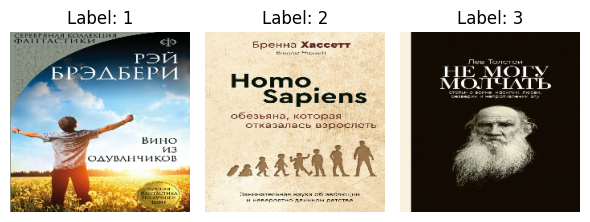

In [ ]:
display_examples( images = flip_book_images_validation[42:],
                  labels = ['1','2','3'],
                  mode = 'single',
                  num_examples = 3 )

## MODEL BUILD

In [ ]:
from tensorflow.keras import layers, models, optimizers, callbacks, applications, losses

#### STRUCTURE

In [ ]:

book_image_autoencoder = models.Sequential( [

      #Encoder
      layers.Conv2D( filters = 64,
                     kernel_size = (3,3),
                     activation = 'relu',
                     padding = 'same'),
      layers.MaxPool2D( pool_size = (2,2) ),

      layers.Conv2D( filters = 32,
                     kernel_size = (3,3),
                     activation = 'relu',
                     padding = 'same'),
      layers.MaxPool2D( pool_size = (2,2) ),

      layers.Conv2D( filters = 16,
                     kernel_size = (3,3),
                     activation = 'relu',
                     padding = 'same'),
      layers.MaxPool2D( pool_size = (2,2) ),


      #Decoder
      layers.Conv2D( filters = 16,
                     kernel_size = (3,3),
                     activation = 'relu',
                     padding = 'same'),
      layers.UpSampling2D( size = (2,2) ),

      layers.Conv2D( filters = 32,
                     kernel_size = (3,3),
                     activation = 'relu',
                     padding = 'same'),
      layers.UpSampling2D( size = (2,2) ),

      layers.Conv2D( filters = 64,
                     kernel_size = (3,3),
                     activation = 'relu',
                     padding = 'same'),
      layers.UpSampling2D( size = (2,2) ),

      layers.Conv2D( filters = 3,
                     kernel_size = (3,3),
                     activation = 'sigmoid',
                     padding = 'same')

 ] )

In [ ]:
book_image_autoencoder.build( input_shape = (None, 224, 224, 3) )

In [ ]:
book_image_autoencoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,067 (203.39 KB)

 Trainable params: 52,067 (203.39 KB)

 Non-trainable params: 0 (0.00 B)

#### COMPILE

In [ ]:
book_image_autoencoder.compile( optimizer = optimizers.Adam(),
                                loss = losses.MeanSquaredError() )


book_image_autoencoder_early_stopping = callbacks.EarlyStopping( patience = 75,
                                                                 monitor = 'val_loss',
                                                                 restore_best_weights = True )

#### TRAIN

In [ ]:
# Get half of each set
half_train = len(flip_book_images_train) // 2
half_val = len(flip_book_images_validation) // 2

# Train using only half of each set
book_image_autoencoder_training_history = book_image_autoencoder.fit(
                                                                      x = tf.stack(flip_book_images_train[:half_train]),
                                                                      y = tf.stack(flip_book_images_train[:half_train]),
                                                                      validation_data = (
                                                                          tf.stack(flip_book_images_validation[:half_val]),
                                                                          tf.stack(flip_book_images_validation[:half_val])
                                                                      ),
                                                                      epochs = 175,
                                                                      callbacks = [book_image_autoencoder_early_stopping],
                                                                      batch_size = 32,
                                                                      verbose = 1
                                                                     )


Epoch 1/175
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - loss: 0.0846 - val_loss: 0.0373
Epoch 2/175
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - loss: 0.0344 - val_loss: 0.0281
Epoch 3/175
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.0274 - val_loss: 0.0257
Epoch 4/175
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0259 - val_loss: 0.0243
Epoch 5/175
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0237 - val_loss: 0.0222
Epoch 6/175
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.0220 - val_loss: 0.0204
Epoch 7/175
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - loss: 0.0203 - val_loss: 0.0199
Epoch 8/175
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.0197 - val_loss: 0.0197
Epoch 9/175
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0197 - val_loss: 0.0189
Epoch 10/175
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0189 - val_loss: 0.0185
Epoch 11/175
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0191 - val_loss: 0.0182
Epoch 12/175
50/50 ━━━━━━━━━━━━━━

#### EVALUATE

In [ ]:
book_image_autoencoder_test_predictions = book_image_autoencoder.predict( tf.stack(flip_book_images_test) )

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step


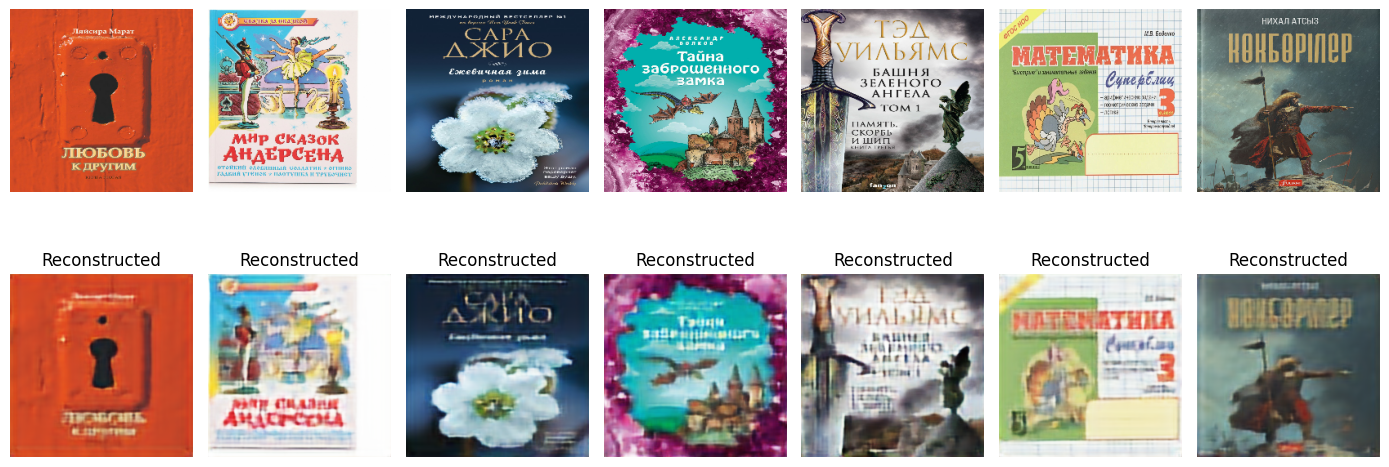

In [ ]:
display_examples_ext( images = flip_book_images_test,
                      reconstructed_images = book_image_autoencoder_test_predictions,
                      num_examples = 7,
                      mode = 'compare' )

#### EMBEDER

In [26]:
encode_layers = []

for layer in book_image_autoencoder.layers:

  encode_layers.append(layer)

  if layer.name == "max_pooling2d_5":
    break



In [38]:
book_image_encoder = models.Sequential( [*encode_layers,
                                         layers.GlobalAveragePooling2D()] )

In [39]:
book_image_encoder.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (32, 224, 224, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 112, 112, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 112, 112, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 56, 56, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 56, 56, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 28, 28, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,880 (97.19 KB)

 Trainable params: 24,880 (97.19 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
book_image_encoder_test_embeddings = book_image_encoder.predict( tf.stack(flip_book_images_test) )

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [43]:
book_image_encoder_test_embeddings.shape

(1000, 16)

#### SAVE

In [ ]:
book_image_autoencoder.save("book_image_autoencoder52t.keras")

In [44]:
book_image_encoder.save("book_image_encoder24t.keras")